In [12]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [1]:
import ast
import os
import re
import time


import pandas as pd
import numpy as np
import seaborn as sns

from datetime import date, datetime


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


pd.options.display.max_colwidth = 280

In [1]:
import gensim

ModuleNotFoundError: No module named 'gensim'

In [6]:
from pandas.io.json import json_normalize
from nltk.tokenize import TweetTokenizer
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy pour lemmatization
import spacy

# Importer la liste de stopword NLTK
import nltk; nltk.download('stopwords'); nltk.download("words")
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Ajouter certains stopwords en fonction du corpus de données si nécessaire
# stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'nan', 'rt'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, string
import nltk
from nltk.collocations import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora, models
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jeanberyl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/jeanberyl/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
df = pd.read_csv("resources/table_clean_topjuly16.csv", index_col = 0)

df.head()

,tweet_id,date,full_text,user,entities,short_url,number_urls,hashtags,user_mentions,media_url,full_text_processed
0,1283356992803868672,2020-07-15 11:05:25,le patron du pétrole de schiste dit que les etats unis ont passé leur pic traduction ici,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/w5MuRmDNnN', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10159506535177281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [92, 115]}, {'url': 'https://t.co/...","['https://t.co/w5MuRmDNnN', 'https://t.co/kx6WIwPNSs']",2,[],[],no_media,patron pétrole schiste etats unis pic traduction ici
1,1282394849870852098,2020-07-12 19:22:12,six mois sur une planète en crise carnet de voyage de greta thunberg des états unis à davos,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/DEskLJXWqU', 'expanded_url': 'https://medium.com/@jmj.fanpage/six-mois-sur-une-plan%C3%A8te-en-crise-carnet-de-voyage-de-greta-thunberg-des-%C3%A9tats-unis-%C3%A0-davos-629d92cef9cd', 'display...",['https://t.co/DEskLJXWqU'],1,[],[],no_media,mois planète crise carnet voyage greta thunberg états unis davos
2,1280935871471144962,2020-07-08 18:44:45,matthieu auzanneau de the shift project à propos du pic pétrolier en europe d ici 2030 si on sort du pétrole pour le climat nous sommes sauvés de mad max,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/lAC3hwH4o2', 'expanded_url': 'https://www.goodplanet.info/2020/07/08/matthieu-auzanneau-de-the-shift-project-a-propos-du-pic-petrolier-en-europe-dici-2030-si-on-sort-du-petrole-pour-le-climat-...",['https://t.co/lAC3hwH4o2'],1,[],[],no_media,matthieu auzanneau the shift project propos pic pétrolier europe d ici 2030 sort pétrole climat sommes sauvés mad max
3,1280850548518981633,2020-07-08 13:05:42,interview 3 50 jean marc jancovici revient sur la question climatique et de la croissance pour lui nous ne nous occupons pas du problème climatique alors qu il menace des milliards de personnes et l économie mondiale,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/YBmq94THuR', 'expanded_url': 'https://www.youtube.com/watch?v=ZsMSF0l9kyM', 'display_url': 'youtube.com/watch?v=ZsMSF0…', 'indices': [224, 247]}]}",['https://t.co/YBmq94THuR'],1,[],[],no_media,interview 3 50 jean marc jancovici revient question climatique croissance occupons problème climatique qu menace milliards personnes l économie mondiale
4,1280180257669238795,2020-07-06 16:42:12,vers un plan de transformation de l économie en faveur du climat et de la résilience the shift project vidéo 5 50,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/TWYTNdhx7t', 'expanded_url': 'https://www.youtube.com/watch?v=3sePULu7YIs&feature=youtu.be', 'display_url': 'youtube.com/watch?v=3sePUL…', 'indices': [118, 141]}]}",['https://t.co/TWYTNdhx7t'],1,[],[],no_media,plan transformation l économie faveur climat résilience the shift project vidéo 5 50


In [4]:
df["full_text_processed"] = df["full_text_processed"].values.astype("U")

In [9]:
df["short_url"].value_counts()

[]                             4188
['https://t.co/Wv114ORtx6']      12
['https://t.co/MPR4EvNgkr']      12
['https://t.co/EpUae2eJ56']      10
['https://t.co/II3T80W6yg']      10
                               ... 
['https://t.co/tgC8R8Rj5T']       1
['https://t.co/fsrbpFTmB5']       1
['https://t.co/6O6p6TFRiX']       1
['https://t.co/yWrCzesWAv']       1
['https://t.co/IHfy1INBWK']       1
Name: short_url, Length: 4369, dtype: int64

In [10]:
brut = pd.read_csv("resources/extract/table_max_july15.csv")

brut.head()        

,Unnamed: 0,tweet_id,date,full_text,user,entities
0,0,1283356992803868672,2020-07-15 11:05:25,Le patron du pétrole de schiste dit que les Etats-Unis ont passé leur pic.\nTraduction ici : https://t.co/w5MuRmDNnN\n\nhttps://t.co/kx6WIwPNSs,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/w5MuRmDNnN', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10159506535177281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [92, 115]}, {'url': 'https://t.co/..."
1,1,1282394849870852098,2020-07-12 19:22:12,Six mois sur une planète en crise: Carnet de voyage de Greta Thunberg des États-Unis à Davos \nhttps://t.co/DEskLJXWqU,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/DEskLJXWqU', 'expanded_url': 'https://medium.com/@jmj.fanpage/six-mois-sur-une-plan%C3%A8te-en-crise-carnet-de-voyage-de-greta-thunberg-des-%C3%A9tats-unis-%C3%A0-davos-629d92cef9cd', 'display..."
2,2,1280935871471144962,2020-07-08 18:44:45,"Matthieu Auzanneau de The Shift Project à propos du pic pétrolier en Europe d’ici 2030 : « si on sort du pétrole pour le climat, nous sommes sauvés de Mad Max »\nhttps://t.co/lAC3hwH4o2",JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/lAC3hwH4o2', 'expanded_url': 'https://www.goodplanet.info/2020/07/08/matthieu-auzanneau-de-the-shift-project-a-propos-du-pic-petrolier-en-europe-dici-2030-si-on-sort-du-petrole-pour-le-climat-..."
3,3,1280850548518981633,2020-07-08 13:05:42,"Interview (3'50) : Jean-Marc Jancovici revient sur la question climatique et de la croissance. Pour lui, nous ne nous occupons pas du problème climatique alors qu’il menace des milliards de personnes et l’économie mondiale.\nhttps://t.co/YBmq94THuR",JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/YBmq94THuR', 'expanded_url': 'https://www.youtube.com/watch?v=ZsMSF0l9kyM', 'display_url': 'youtube.com/watch?v=ZsMSF0…', 'indices': [224, 247]}]}"
4,4,1280180257669238795,2020-07-06 16:42:12,Vers un Plan de transformation de l'économie en faveur du climat et de la résilience - The Shift Project (vidéo 5'50)\nhttps://t.co/TWYTNdhx7t,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/TWYTNdhx7t', 'expanded_url': 'https://www.youtube.com/watch?v=3sePULu7YIs&feature=youtu.be', 'display_url': 'youtube.com/watch?v=3sePUL…', 'indices': [118, 141]}]}"


### Des textes vides

In [11]:
df[df["full_text"].isna()]

,tweet_id,date,full_text,user,entities,short_url,number_urls,hashtags,user_mentions,media_url,full_text_processed
159,1226489238042091521,2020-02-09 12:53:16,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/Af6wgi4YAG', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_eni-est-ce-que-lon-appelle-un-p%C3%A9trolier-activity-6632216920605237248-3gyD', 'display_url': 'linkedin.com/p...",['https://t.co/Af6wgi4YAG'],1,[],[],no_media,nan
169,1226240910532521984,2020-02-08 20:26:30,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/28vS5oMNA9', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_le-directeur-de-centrale-nantes-doit-%C3%AAtre-activity-6631440454661615616-Gkq1', 'display_url': 'linkedin.com...",['https://t.co/28vS5oMNA9'],1,[],[],no_media,nan
197,1215071608840298498,2020-01-09 00:43:41,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/87aUdyrPMS', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10158888602852281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/87aUdyrPMS'],1,[],[],no_media,nan
66,1199280950108205057,2019-11-26 10:57:14,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/en6gbWF867', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_5g-larcep-donne-le-coup-denvoi-aux-exp%C3%A9rimentations-activity-6605029251643248641-23Aw', 'display_url': 'li...",['https://t.co/en6gbWF867'],1,[],[],no_media,nan
78,1198610352612794369,2019-11-24 14:32:31,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/IdOF0YInsh', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_chinese-credit-collapse-is-imminent-activity-6603964102232682496-T3Ol', 'display_url': 'linkedin.com/posts/jean...",['https://t.co/IdOF0YInsh'],1,[],[],no_media,nan
119,1066950650867650560,2018-11-26 07:03:52,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/mNX4rqx06D', 'expanded_url': 'https://www.facebook.com/54658232280/posts/10157840565017281/', 'display_url': 'facebook.com/54658232280/po…', 'indices': [0, 23]}]}",['https://t.co/mNX4rqx06D'],1,[],[],no_media,nan
42,1055033296034451456,2018-10-24 09:48:34,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/b4jg4RPaNz', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157763499342281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/b4jg4RPaNz'],1,[],[],no_media,nan
25,1014508307833384960,2018-07-04 13:56:43,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/W8OAPxcGXv', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157497343467281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/W8OAPxcGXv'],1,[],[],no_media,nan
47,1012056866912985089,2018-06-27 19:35:34,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/hp2Lj65dxa', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157479600412281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/hp2Lj65dxa'],1,[],[],no_media,nan
180,998975355066167297,2018-05-22 17:14:19,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ETeNue3DLK', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157389523532281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/ETeNue3DLK'],1,[],[],no_media,nan


In [7]:
# il y en avait 32

In [12]:
df["full_text"].isna().value_counts()

False    8844
True       29
Name: full_text, dtype: int64

In [8]:
df["full_text"].isna().value_counts()

False    8831
True       32
Name: full_text, dtype: int64

In [27]:
# why non utf-8 strings?

In [8]:
df.shape

(8873, 11)

In [4]:
df.shape

(8482, 12)

In [14]:
brut.iloc[7549]

Unnamed: 0                                                                                                                                                                                                                                                                                        135
tweet_id                                                                                                                                                                                                                                                                          1219271834090250244
date                                                                                                                                                                                                                                                                              2020-01-20 14:53:52
full_text                                                                                                             

In [16]:
brut.iloc[7549]["entities"]

"{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Jardin_Acide', 'name': 'Nabil Laroussi', 'id': 862427256509128704, 'id_str': '862427256509128704', 'indices': [0, 13]}], 'urls': [], 'media': [{'id': 1219271829304545281, 'id_str': '1219271829304545281', 'indices': [37, 60], 'media_url': 'http://pbs.twimg.com/media/EOu5RM5WkAE-c7t.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EOu5RM5WkAE-c7t.jpg', 'url': 'https://t.co/6ZSTLviAut', 'display_url': 'pic.twitter.com/6ZSTLviAut', 'expanded_url': 'https://twitter.com/maxcordiez/status/1219271834090250244/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 701, 'resize': 'fit'}, 'small': {'w': 680, 'h': 398, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 1348, 'h': 788, 'resize': 'fit'}}}]}"

In [11]:
df.iloc[7549]

tweet_id                                                                                                                                                                                                                                                                                   1219271834090250244
date                                                                                                                                                                                                                                                                                       2020-01-20 14:53:52
full_text                                                                                                                                                                                                                                               jardin_acide ou de l algérie 6 x https t co 6zstlviaut
user                                                                                       

In [9]:
df["media_url"].value_counts()

no_media                       8175
['https://t.co/z0ugMNPHWH']       2
['https://t.co/lqaWqRFesZ']       2
['https://t.co/WboetMftjB']       2
['https://t.co/M7I4fotF4g']       2
                               ... 
['https://t.co/EYUSW1JLxc']       1
['https://t.co/81vrNHQjYU']       1
['https://t.co/BpTsrooZTc']       1
['https://t.co/tZwe7cNq7p']       1
['https://t.co/WtVDlPkE3w']       1
Name: media_url, Length: 694, dtype: int64

In [24]:
df.iloc[7542]["media_url"]

'no_media'

In [23]:
len(df.iloc[7542]["media_url"])

8

In [10]:
df["user_mentions"].value_counts()

[]                                                                                                  4284
['theShiftPR0JECT']                                                                                  209
['Carbone4']                                                                                         132
['maxcordiez']                                                                                        55
['bensabaugcap']                                                                                      43
                                                                                                    ... 
['boris_lengoc', 'sdnfr', 'TristanKamin', 'Kako_line', 'AStrochnis', 'BenjiLAREDO', 'MacLesggy']       1
['nntaleb']                                                                                            1
['laydgeur', 'LoveIslandFR', 'Nabilla']                                                                1
['bensabaugcap', 'XavierGorce']                        

In [5]:
brut.iloc[7549]["full_text"]

'« Nous estimons que près d’un cinquième de la ↗️ mondiale de la consommation d’#énergie en 2018 est imputable à des étés plus chauds, poussant à la hausse la demande de refroidissement, et aux vagues de froid, entraînant une augmentation des besoins en chauffage. » @IEA, WEO2019 https://t.co/u4ln0a7m5R'

In [4]:
brut.iloc[7549].entities

"{'hashtags': [{'text': 'énergie', 'indices': [79, 87]}], 'symbols': [], 'user_mentions': [{'screen_name': 'IEA', 'name': 'IEA', 'id': 84679163, 'id_str': '84679163', 'indices': [266, 270]}], 'urls': [], 'media': [{'id': 1194993950194573312, 'id_str': '1194993950194573312', 'indices': [280, 303], 'media_url': 'http://pbs.twimg.com/media/EJV4qpYWoAASbdK.png', 'media_url_https': 'https://pbs.twimg.com/media/EJV4qpYWoAASbdK.png', 'url': 'https://t.co/u4ln0a7m5R', 'display_url': 'pic.twitter.com/u4ln0a7m5R', 'expanded_url': 'https://twitter.com/maxcordiez/status/1194993954330173446/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 529, 'resize': 'fit'}, 'small': {'w': 680, 'h': 300, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 1335, 'h': 589, 'resize': 'fit'}}}]}"

In [20]:
brut.iloc[6274]["full_text"] 

"Les fournisseurs d'électricité alternatifs (à EDF) sont contents de pouvoir acheter de l'électricité nucléaire à bas prix pour la revendre en faisant une marge via le dispositif #ARENH quand elle coûte cher.\n\n[1/X]\n\nhttps://t.co/a2OwJa9vMW"

In [27]:
df.iloc[6274]["full_text"] 

'les fournisseurs d électricité alternatifs à edf sont contents de pouvoir acheter de l électricité nucléaire à bas prix pour la revendre en faisant une marge via le dispositif arenh quand elle coûte cher 1 x '

In [21]:
df.iloc[6274]

tweet_id                                                                                                                                                                                                                                                                                   1247549090289856512
date                                                                                                                                                                                                                                                                                       2020-04-07 15:37:36
full_text                                                                les fournisseurs d électricité alternatifs à edf sont contents de pouvoir acheter de l électricité nucléaire à bas prix pour la revendre en faisant une marge via le dispositif arenh quand elle coûte cher 1 x https t co a2owja9vmw
user                                                                                       

In [1]:
# # tokens uniques
vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(df["full_text_processed"])
# print(vectorizer.get_feature_names())

In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["full_text_processed"])
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0_c59e2fd7a9', '0vinz', '0xilight', '10', '100', '1000', '10000', '100000', '1000ppm', '100k', '103', '105', '10500', '1055', '107', '10bn', '10e', '10gco2', '10h', '10h20', '10mds', '10mrd', '10àlasuite', '10ème', '11', '110', '1100', '11000', '111', '112', '113', '114', '115013739', '117', '1170', '119', '11h', '11ème', '12', '120', '1200', '121', '122', '123', '1240', '125', '1250', '1258', '12gco2', '12h', '12h00', '12h08', '12h14h', '12h30', '12h40', '12k', '13', '130', '1300', '131', '133', '1332', '1335', '1346', '135', '1350', '137', '13h', '13h15', '13h30', '14', '140', '141', '144', '145', '1458', '147', '1479', '14h', '14h00', '14h15', '14h30', '15', '150', '1500', '15000', '150k', '151', '157', '159', '15h', '15h00', '15marches', '16', '160', '164', '16h', '16h30', '16th', '17', '170', '172', '173', '175', '176', '1782', '17h', '17h30', '17h40', '17h45', '17th', '18', '180', '1800', '180degresvp', '1817', 

In [13]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df["full_text_processed"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)
#df_tfidf

In [ ]:
#SUR LES LEMS
#Ici le calcul des descripteurs est uniquement exploratoire, il s'agit de faire ressortir les associations de mots fréquentes afin de fusionner celles qui forment une expression sensée

#Matrice des bigrams (association de deux mots)
vect_count_bigrams = CountVectorizer(min_df=5, ngram_range=(2,2)).fit(dff['lemmas'])
lem_gram_vect = vect_count_bigrams.transform(dff['lemmas'])
lem_gram = pd.DataFrame(lem_gram_vect.todense()).rename(columns=renomecol(vect_count_bigrams))

#Matrice des trigrams (association de trois mots)
vect_count_trigrams = CountVectorizer(min_df=1, ngram_range=(3,3)).fit(dff['lemmas'])
lem_trigram_vect = vect_count_trigrams.transform(dff['lemmas'])
lem_trigram = pd.DataFrame(lem_trigram_vect.todense()).rename(columns=renomecol(vect_count_trigrams))

In [6]:
data = df["full_text_processed"].values.tolist()

In [7]:
#tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations
data_words = list(sent_to_words(data))

# création de bigram et trigram pour analyse ultérieures
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Définir les fonctions pour les stopwords, bigrams et lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation (https://spacy.io/api/annotation)"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Retirer les Stopwords
data_words_nostops = remove_stopwords(data_words)

# Créer les bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# S'assurer que spacy utilise la langue approprié pour le corpus (dans ce cas-ci l'anglais)
# Télécharger la langue au besoin avec cette commande dans un terminal
# python3 -m spacy download en
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# Lemmatization (permet de ne conserver que les noms, adj, verbes et adverbes)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

/home/jeanberyl/anaconda3/envs/nlp/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/home/jeanberyl/anaconda3/envs/nlp/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/jeanberyl/anaconda3/envs/nlp/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)


In [8]:
# Créer le dictionnaire
id2word = corpora.Dictionary(data_lemmatized)
# Créer le corpus
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    from gensim.models.ldamodel import LdaModel
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=1, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Calculer les scores de cohérence entre 2 et 40 topics (Cela peut prendre un certain temps)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

# Afficher un graphique
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Affchier les coherence scores
# for m, cv in zip(x, coherence_values):
#    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))  #le 4 correspond au nombre de décimales du c

NameError: name 'id2word' is not defined

In [2]:
# # Construire le modèle LDA
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=1, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# # Afficher le Perplexity score
# print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

# # #Afficher le Coherence Score
# # coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# # coherence_lda = coherence_model_lda.get_coherence()
# # print('\nCoherence Score: ', coherence_lda)

In [1]:
 #lda_model.log_perplexity(corpus)

In [10]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.275807  0.031657       1        1  27.522446
2     -0.105559  0.225466       2        1  23.019487
0     -0.061413 -0.137218       3        1  18.870930
3     -0.059840 -0.070705       4        1  17.283804
4     -0.048995 -0.049200       5        1  13.303335, topic_info=            Term        Freq       Total Category  logprob  loglift
141      energie  652.000000  652.000000  Default  30.0000  30.0000
2        petrole  589.000000  589.000000  Default  29.0000  29.0000
314     nucleair  362.000000  362.000000  Default  28.0000  28.0000
1293          rt  279.000000  279.000000  Default  27.0000  27.0000
12        climat  366.000000  366.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
10160      saudi   50.734379   52.023724   Topic5  -5.4780   1.9921
10521       iraq   41.351059   42.421253   Topic5  -5.6825   1.9916
10976   aubl_bru   39.339577   40.424969   Topic5  -5.7324   1.9899
8201   shale_oil   57.391079   61.880756   Topic5  -5.3548   1.9418
8069       would   35.800095   36.672573   Topic5  -5.8267   1.9931

[189 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
951       1  0.998262      accord
532       4  0.991254      actuel
1243      2  0.992030        agir
701       5  0.989757  alternatif
1274      3  0.997963         amp
...     ...       ...         ...
1556      3  0.995057     vouloir
400       3  0.993408    vraiment
5728      5  0.987043       world
8069      5  0.981660       would
482       2  0.993320      youtub

[163 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

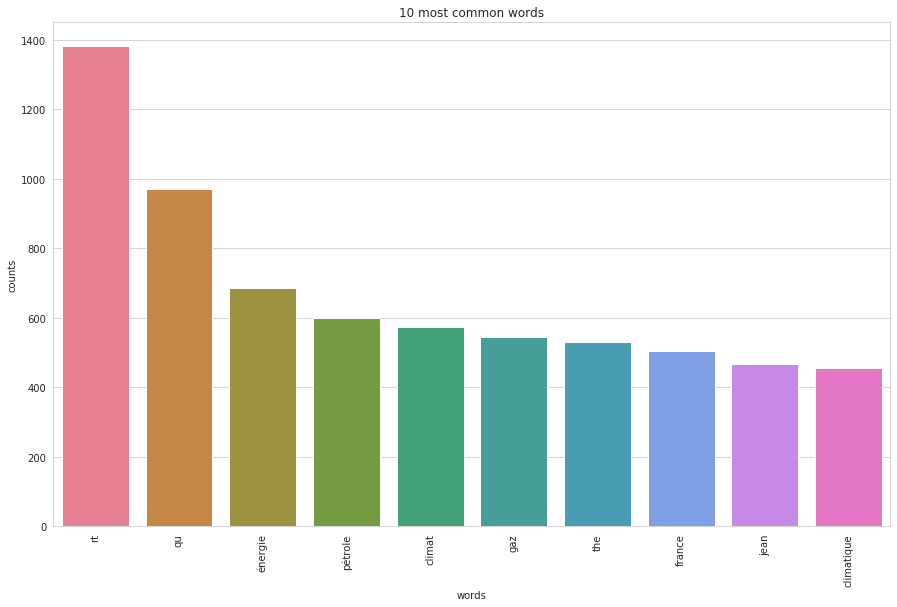

In [5]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
count_vectorizer = CountVectorizer(ngram_range=(1, 2))# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df["full_text_processed"])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [6]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 15
number_words = 200# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
rt climat the qu theshiftpr0ject in gaz pays rt theshiftpr0ject and europe énergie nucléaire pétrole figarovox le_figaro rt carbone4 carbone4 électricité carbone production monde le_figaro figarovox amp oui france is charbon of faire faut centrales climatique ici mobilité demande fossiles to fois exemple climate inscrire oubliez oubliez inscrire bonne ganumab le_figaro ganumab prix change paris 10 écologique recevoir crise réserves lire commentaire décryptages mobilité recevoir décryptages décryptages carbone4 recevoir mobilité oubliez oil_men veut oil consommation in the tristankamin gouvernement grand industrie accord an temps this mois déjà rapport combustible pic coût question énergétique français ans face jmjancovici idirtfr urgence électrique maxencebrossard grande déclin us années étude cha_mijeon conseil shift plan croissance sujet for climate change pib jamais rapide centrales charbon solaire chose are déchets extraction millions pierregilbert 

In [ ]:
# Afficher le Perplexity score
# print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

#Afficher le Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [7]:
%%time

from pyLDAvis import sklearn as sklearn_lda

import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()



LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
        


LDAvis_prepared

CPU times: user 53.2 s, sys: 268 ms, total: 53.4 s
Wall time: 58.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.075237  0.071288       1        1  8.159713
4     -0.123712  0.066018       2        1  8.122667
3      0.074991  0.108507       3        1  7.785418
7     -0.011201  0.025401       4        1  7.349719
11    -0.016335 -0.009776       5        1  7.173016
12     0.101874  0.025027       6        1  6.733082
0      0.054113  0.015481       7        1  6.700136
6      0.036325  0.006770       8        1  6.566750
1     -0.005670 -0.055612       9        1  6.495479
10    -0.001127 -0.057602      10        1  6.392854
9     -0.043533 -0.055194      11        1  6.381170
8      0.001293 -0.091399      12        1  6.345690
13    -0.033183 -0.005233      13        1  5.417270
5      0.004072 -0.020360      14        1  5.222510
14     0.037330 -0.023316      15        1  5.154526, topic_info=                  Term        Freq       Total Category  logprob  loglift
51556        jean marc  285.000000  285.000000  Default  30.0000  30.0000
56709             marc  288.000000  288.000000  Default  29.0000  29.0000
56715   marc jancovici  280.000000  280.000000  Default  28.0000  28.0000
51113        jancovici  309.000000  309.000000  Default  27.0000  27.0000
51536             jean  336.000000  336.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
59776            monde   13.148926  237.493136  Topic15  -6.7931   0.0715
64421               of   12.413126  168.438985  Topic15  -6.8506   0.3575
92557               to   12.298086  194.418438  Topic15  -6.8599   0.2047
91768  theshiftpr0ject   11.892704  288.085429  Topic15  -6.8935  -0.2220
19987              co2   11.708827  196.983414  Topic15  -6.9090   0.1425

[1169 rows x 6 columns], token_table=        Topic      Freq                   Term
term                                          
124         1  0.039452                     10
124         2  0.049315                     10
124         3  0.128220                     10
124         4  0.019726                     10
124         5  0.147946                     10
...       ...       ...                    ...
102893     11  0.089773             états unis
102893     12  0.269319             états unis
102893     13  0.017955             états unis
102893     15  0.071819             états unis
103153      4  0.715599  évaluation climatique

[3583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 8, 12, 13, 1, 7, 2, 11, 10, 9, 14, 6, 15])

In [38]:
%%time

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte